# Variational Linear Systems via QAOA

Ryan LaRose, Yigit Subasi, Lukasz Cincio, Patrick Coles

### Abstract

In this notebook, we implement an approach to solving linear systems on a NISQ computer. The approach uses QAOA [1] with the "linear system Hamiltonian" given in [2]. Other approaches for the "quantum linear systems problem" [3-5] require resources beyond current hardware capabilities. This method can be implemented on NISQ processors. Other "near-term approaches" have recently emerged in the literature [6-7].

In [1]:
"""Imports for the notebook.

Requires:
    Matplotlib
    Numpy
    Scipy
    Cirq v0.5.0
"""
from time import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.optimize import minimize

import cirq
assert cirq.__version__ == "0.5.0", "Wrong version of Cirq! Code may or may not work."

In [2]:
"""Flags for testing behavior."""
DEBUG = True

## Preliminaries

We seek to solve the "quantum linear systems problem" (QLSP) defined by the system

\begin{equation}
    A \mathbf{x} = \mathbf{b}
\end{equation}

where $A \in \mathbb{R}^{N \times N}$ and $N = 2^n$. QLSP is similar to the classical linear systems problem except we only want to output a "quantum description" of the solution

\begin{equation}
    | \mathbf{x} \rangle = |A^{-1} \mathbf{b} \rangle
\end{equation}

(because we don't have a good way around this).

#### Challenge: Find a (practical) problem where we only want some expectation of the solution $\langle \mathbf{x} | \hat{O} | \mathbf{x} \rangle$ for some Hermitian operator $\hat{O}$.

## Ansatz wavefunction

_Note: This presentation is based off the slides Yigit presented at SQUINT 2019._

We follow the method outlined in [2] to construct our ansatz wavefunction. First, define the projector

\begin{equation}
    P_\mathbf{b}^\perp := I - |\mathbf{b}\rangle \langle \mathbf{b}| .
\end{equation}

Since $P_\mathbf{b}^\perp |\mathbf{b} \rangle = \mathbf{0}$, we have

\begin{equation}
    P_\mathbf{b}^\perp A | \mathbf{x} \rangle = \mathbf{0} .
\end{equation} 

Define $B := P_\mathbf{b}^\perp A$ and the operator

\begin{equation}
    H_f := B^\dagger B = A P_\mathbf{b}^\perp A .
\end{equation} 

The subscript $f$ will become apparent shortly. This operator (Hamiltonian) is:

* Hermitian. 
* positive-semidefinite $\implies$ $|\mathbf{x}\rangle$ is the ground state.

Note that $|\mathbf{x}\rangle$ is the _unique_ ground state since $P_\mathbf{b}^\perp$ is an $N - 1$ dimensional projector.

We now parameterize the linear system $A$ with the schedule

\begin{equation}
    A \mapsto A(t) := (1 - t) I + t A
\end{equation}

for $0 \le t \le 1$ and similarly the Hamiltonian

\begin{equation}
        H(t) := A(t) P_\mathbf{b}^\perp A(t)  .
\end{equation} 

Note that $H(t=1) = H_f$. 

This defines our "driver Hamiltonian" in QAOA, i.e. the unitary operator

\begin{equation}
    U_t(\gamma) = e^{ - i \gamma H(t) }
\end{equation}

#### Question: Normally, the "cost Hamiltonian" in QAOA is assumed to be diagonal in the computational basis. In general, our Hamiltonian is not. Do we need a separate "mixer Hamiltonian" in this case?

#### Note: QAOA typically assumes the driver Hamiltonian is time-independent (so far as I know), but our Hamiltonian is time-dependent. 

We will, for now, take the standard mixer Hamiltonian

\begin{equation}
    V(\beta) = \prod_j e^{ - i \beta X_j} ,
\end{equation}

i.e., a rotation of each qubit about the $x$-axis by $2 \beta$. 

The ansatz wavefunction is thus

\begin{equation}
    |\mathbf{\gamma}, \mathbf{\beta} \rangle := \left[ \prod_{1}^{p} U_{t_i} (\gamma_i) V(\beta_i) \right] H^{\otimes n} |0\rangle^{\otimes n}
\end{equation}

where $n := \log_2 N$. 

# Code Implementation

We now turn to a implementation of this algorithm using Cirq.

## Example Problem

In the cells below we'll generate a random linear system of equations.

In [3]:
"""Seed the random number generator."""
SEED = 8675309
np.random.seed(SEED)

In [4]:
"""Generate a system of equations to solve."""
# Dimension of system. Assume square for now
# Note: Studying different systems is (unfortunately) not as
# simple as changing n, since we defined the driver Hamiltonian
# as a cirq.TwoQubitGate
# TODO: Can this be changed to cirq.Gate?
n = 2
N = 2**n

if DEBUG:
    A = np.identity(4)
else:
    # Generate a random matrix
    A = np.random.rand(N, N)

    # Make sure it's Hermitian
    A = A + A.conj().T

    # Normalize it WLOG. Note this defaults to the Froebenius norm for matrices.
    A /= np.linalg.norm(A)

if DEBUG:
    b = np.array([1.0, 0.0, 0.0, 0.0], dtype=float)
else:
    # Generate the vector
    b = np.random.rand(N)

    # Normalize it WLOG. Note this defaults to the l2-norm for vectors.
    b /= np.linalg.norm(b)

# Do the solution classically
start = time()
x = np.linalg.solve(A, b)
total = time() - start

# Display the system, solution, and time to solve
print("Classically solving the system Ax = b...")
print("A =\n", A)
print("b =\n", b)
print()
print("Solution found in", total, "seconds.")
print("x =\n", x)
print("Ax =\n", np.dot(A, x))

Classically solving the system Ax = b...
A =
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
b =
 [1. 0. 0. 0.]

Solution found in 0.008698701858520508 seconds.
x =
 [1. 0. 0. 0.]
Ax =
 [1. 0. 0. 0.]


## Building up the ansatz

Now we'll build up the ansatz. We'll "cheat" a little by

1. Allowing for matrix gates (to avoid compiling).
1. Classically exponentiating the system (to avoid Trotterization).

We'll use the "half-way point" Hamiltonian. That is, setting $t = 0.5$ in the Hamiltonian $H(t)$. 

In [5]:
"""Get the matrix for the driver Hamiltonian."""
# Set the time for the Hamiltonian
t = 1.0

# Identity matrix, for convenince
iden = np.identity(N)

# Get the "b^\perp projector"
Pb = iden - np.outer(b, b)

# Get the parameterized linear system
At = (1.0 - t) * iden + t * A

# Get the Hamiltonian
Ht = At @ Pb @ At

# Make sure it's Hermitian
assert np.allclose(Ht, Ht.conj().T)

This gives us a matrix representation of the $U_t(\gamma)$ unitary -- except without the $\gamma$ parameter. We'll take care of this when we construct a matrix gate in Cirq by raising the gate to the power $\gamma$. We now construct a gate from this unitary that we can use in a circuit.

In [6]:
"""Create a gate for the driver Hamiltonian (unitary)."""
class Driver(cirq.TwoQubitGate):
    """Gate for the U_t(\gamma) driver Hamiltonian (for a particular t)."""
    
    def __init__(self, H, gamma):
        self.gamma = gamma
        self.matrix = expm(-1j * gamma * H)
        assert np.allclose(self.matrix @ self.matrix.conj().T, iden)
    
    def _unitary_(self):
        return self.matrix
    
    def _circuit_diagram_info_(self, args):
        return "Driver^{}".format(self.gamma), "Driver^{}".format(self.gamma)

In [7]:
Ht

array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Now we'll make sure we can implement this in a quantum circuit.

In [8]:
"""Function for building the ansatz circuit."""
def circuit(gamma, beta):
    """Returns the state |gamma, beta> defined above."""
    # Get a qubit register
    qreg = cirq.LineQubit.range(n)

    # Get a quantum circuit
    circ = cirq.Circuit()

    # How about a round of Hadamards?
    circ.append(cirq.H.on_each(*qreg))

    # Do the driver Hamiltonian
    U = Driver(Ht, gamma)
    circ.append(U.on(*qreg))

    # Do the mixer Hamiltonian
    circ.append(cirq.Rx(beta).on_each(*qreg))
    
    return circ

In [9]:
"""Make sure the code above is working properly."""
# Display the circuit
circ = circuit(0, 0)
print("Circuit:")
print(circ)

# Make sure it can be simulated
sim = cirq.Simulator()
res = sim.simulate(circ)

# Display the final state
print("\nFinal state:")
print("|psi> = ", *res.final_state)

Circuit:
0: ───H───Driver^0───Rx(0.0π)───
          │
1: ───H───Driver^0───Rx(0.0π)───

Final state:
|psi> =  (0.49999997+0j) (0.49999997+0j) (0.49999997+0j) (0.49999997+0j)


## Computing the Expectation Value

To compute the expectation value (cost), we use the final Hamiltonian $H_f$:

\begin{equation}
    C(\mathbf{\gamma}, \mathbf{\beta}) = 
        \langle \mathbf{\gamma}, \mathbf{\beta} | H_f | \mathbf{\gamma}, \mathbf{\beta} \rangle
\end{equation}

It is this quantity we minimize during the optimization procedure.

In [10]:
"""Function for computing the cost."""
def cost(gamma, beta, simulator=cirq.Simulator()):
    """Returns the cost C(\gamma, \beta) defined above."""
    # Build the circuit
    circ = circuit(gamma, beta)
    
    # Get the final state
    psi = sim.simulate(circ).final_state
    
    # Return the expectation <\gamma, \beta| Hf | \gamma, \beta>
    Hf = A @ Pb @ A
    return abs(np.dot(psi.conj().T, np.dot(Hf, psi)))

## Minimizing the cost

We now minimize the cost. For simplicity, we use built-in optimizers from Scipy. Alternatively, a dynamic grid search or analytic-gradient methods could be used.

In [11]:
"""Function that returns the objective and inputs an array (for Scipy)."""
# Functional form for scipy.optimize.minimize
def obj(x):
    val = cost(x[0], x[1])
    print("Current cost:", val, end="\r")
    return val

In [12]:
"""Do the minimization and time it."""
start = time()
out = minimize(obj, np.random.rand(2), method="Powell")
total = time() - start

In [13]:
print(out["x"])

[-1.91068975  1.23071292]


## Doing a grid search over the landscape

Here we visualize the cost landscape by evaluating the cost on a grid.

In [14]:
"""Do a grid search over all angles."""
# Define ranges of parameters to search over
gammas = np.linspace(-3, 3, 100)
betas = np.linspace(-np.pi, np.pi, 100)

# Initialize an array to store the costs at each point
costs = np.zeros((100, 100))

# Evaluate the cost at each point and store it
for ii, gamma in enumerate(gammas):
    for jj, beta in enumerate(betas):
        costs[ii, jj] = obj([gamma, beta])

We can now make a 2D plot of the landscape.

Text(0.5,1,'First Order QAOA on Diagonal System')

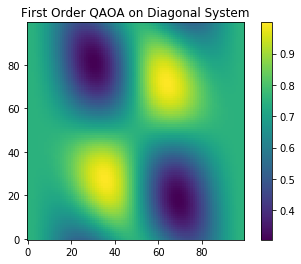

In [15]:
"""Plot the cost landscape."""
plt.imshow(costs, origin="lower")
plt.colorbar()
plt.title("First Order QAOA on Diagonal System")

In [16]:
"""See the quantum solution."""
# Get the wavefunction at the best angles
gamma_opt, beta_opt = out["x"]
circ = circuit(gamma_opt, beta_opt)
xquantum = sim.simulate(circ).final_state

# Display the system, solution, and time to solve
print("Quantumly solving the system Ax = b...")
print("A =\n", A)
print("b =\n", b)
print()
print("Quantum solution found in", total, "seconds.")
print("xquantum =\n", xquantum)
print("xclassical =\n", x)
print("Ax =\n", np.dot(A, xquantum))
print("Overlap with classical solution:", 
      abs(np.dot(xquantum, x))**2 / abs(np.dot(xquantum, xquantum))**2 / abs(np.dot(x, x)**2))

Quantumly solving the system Ax = b...
A =
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
b =
 [1. 0. 0. 0.]

Quantum solution found in 0.24454069137573242 seconds.
xquantum =
 [0.83333325+6.9312751e-05j 0.16659524+1.3262033e-04j
 0.16659524+1.3265014e-04j 0.16664001+4.7146434e-01j]
xclassical =
 [1. 0. 0. 0.]
Ax =
 [0.83333325+6.93127513e-05j 0.16659524+1.32620335e-04j
 0.16659524+1.32650137e-04j 0.16664001+4.71464336e-01j]
Overlap with classical solution: 2.0837279676532483


## Higher order QAOA

We now go beyond one layer $p > 1$ in the QAOA ansatz. This is just a slight modification of the code above.

In [17]:
"""Circuit for higher order QAOA."""
def qaoa(gammas, betas):
    """Returns the state |gamma, beta> defined above."""
    # Make sure we have the correct number of parameters
    if len(gammas) != len(betas):
        raise ValueError("gammas and betas must have the same length.")

    # Get a qubit register
    qreg = cirq.LineQubit.range(n)

    # Get a quantum circuit
    circ = cirq.Circuit()

    # How about a round of Hadamards?
    circ.append(cirq.H.on_each(*qreg))
    
    # Do each layer of QAOA
    for gamma, beta in zip(gammas, betas):
        # Do the driver Hamiltonian
        U = Driver(Ht, gamma)
        circ.append(U.on(*qreg))

        # Do the mixer Hamiltonian
        circ.append(cirq.Rx(beta).on_each(*qreg))
    
    return circ

Let's test this to make sure it works properly.

In [18]:
"""Testing the higher order QAOA circuit."""
gammas = [0, 0, 0]
betas = [0.0, 0.0, 0.0]

circ = qaoa(gammas, betas)

print("Circuit:")
print(circ)

# Make sure it can be simulated
sim = cirq.Simulator()
res = sim.simulate(circ)

# Display the final state
print("\nFinal state:")
print("|psi> = ", *res.final_state)

Circuit:
0: ───H───Driver^0───Rx(0.0π)───Driver^0───Rx(0.0π)───Driver^0───Rx(0.0π)───
          │                     │                     │
1: ───H───Driver^0───Rx(0.0π)───Driver^0───Rx(0.0π)───Driver^0───Rx(0.0π)───

Final state:
|psi> =  (0.49999997+0j) (0.49999997+0j) (0.49999997+0j) (0.49999997+0j)


Now we modify the cost function.

In [19]:
"""Defining the cost function for higher order QAOA."""
def expectation(gammas, betas, simulator=cirq.Simulator()):
    """Returns the cost C(\gamma, \beta) defined above."""
    # Build the circuit
    circ = qaoa(gammas, betas)
    
    # Get the final state
    psi = sim.simulate(circ).final_state
    
    # Return the expectation <\gamma, \beta| Hf |\gamma, \beta>
    Hf = A.conj().T @ Pb @ A
    return abs(np.dot(psi.conj().T, np.dot(Hf, psi)))

And now test it.

In [20]:
"""Testing the cost function for higher order QAOA."""
print(expectation([1, 2], [3, 4]))

0.9047974679014985


And finally minimization for higher order QAOA.

In [21]:
"""Defining the objective function for optimization with multiple layers."""
def objective(x):
    """Returns the objective function for higher order QAOA."""
    # Make sure the number of parameters is valid
    if len(x) % 2 != 0:
        raise ValueError("Invalid number of parameters. Must be even.")
    
    # Parse the parameters (arbitrary convention)
    gammas = x[:len(x) // 2]
    betas = x[len(x) // 2:]
    
    # Compute the expectation for these parameters
    cval = expectation(gammas, betas)
    
    # Print it out
    print("Current cost:", cval, end="\r")
    
    return cval

## Higher order QAOA

Now we look at performing the optimization.

In [22]:
"""Set the number of layers p for QAOA."""
p = 2

In [23]:
"""Optimizing higher order QAOA."""
# Do the minimization
start = time()
out = minimize(objective, np.random.rand(2 * p), method="Powell")
total = time() - start

In [24]:
"""See the quantum solution."""
# Get the wavefunction at the best angles
opt_params = out["x"]
gammas = opt_params[:len(opt_params) // 2]
betas = opt_params[len(opt_params) // 2:]
circ = qaoa(gammas, betas)
xquantum = sim.simulate(circ).final_state

# Display the system, solution, and time to solve
print("Quantumly solving the system Ax = b...")
print("A =\n", A)
print("b =\n", b)
print()
print("Solution found in", total, "seconds.")
print("xquantum =\n", xquantum)
print("xclassical =\n", x / np.linalg.norm(x))
print("Ax =\n", np.dot(A, xquantum))
print("Overlap with classical solution:", 
      abs(np.dot(xquantum, x))**2 / abs(np.dot(xquantum, xquantum))**2 / abs(np.dot(x, x)**2))

Quantumly solving the system Ax = b...
A =
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
b =
 [1. 0. 0. 0.]

Solution found in 1.8229899406433105 seconds.
xquantum =
 [ 8.7508655e-01-4.8396623e-01j  1.4901161e-08+0.0000000e+00j
 -3.7739940e-09+4.8340070e-08j -2.3448182e-08-6.4240266e-09j]
xclassical =
 [1. 0. 0. 0.]
Ax =
 [ 8.75086546e-01-4.83966231e-01j  1.49011612e-08+0.00000000e+00j
 -3.77399401e-09+4.83400697e-08j -2.34481821e-08-6.42402664e-09j]
Overlap with classical solution: 1.0000002528131726


# References

[1] Edward Farhi, Jeffrey Goldstone, Sam Gutmann, A quantum approximate optimization algorithm. https://arxiv.org/abs/1411.4028

[2] Yigit Subasi, Rolando D. Somma, Davide Orsucci, Quantum algorithms for systems of linear equations inspired by adiabatic quantum computing. https://arxiv.org/abs/1805.10549.

[3] A. W. Harrow, A. Hassidim, and S. Lloyd, “Quantum algorithm for solving linear systems of equations,” Physical Review Letters, vol. 103, no. 15, Oct. 2009.


[4] L. Wossnig, Z. Zhao, and A. Prakash, “A quantum linear system algorithm for dense matrices,” Phys. Rev. Lett., vol. 120, no. 5, p. 050502, Jan. 2018.


[5] D. Dervovic, M. Herbster, P. Mountney, S. Severini, N. Usher, and L. Wossnig, “Quantum linear systems algorithms: a primer,” arXiv:1802.08227 [quant-ph], Feb. 2018.


[6] NISQLSP I.

[7] NISQLSP II.